In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as api
import warnings
import os
from joblib import Parallel,delayed
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
#from api.单因子分析框架 import *
warnings.filterwarnings('ignore')

In [2]:
#策略回测时间段为2012至2020年，读取的close数据为日度数据，而因子数据则为月度数据
close =pd.read_csv("D:/causis/close.csv",index_col=0,parse_dates=[0])

In [3]:
#读取pca因子，所有因子都经过预处理，只需要再次标准化
old_path= 'D:/causis/pca_factor/'
all_data= [pd.read_csv(old_path+path,index_col=0,parse_dates=[0]) for path in os.listdir(old_path) if 'csv' in path]

In [4]:
#这里month数据已经统一行与列索引，注意month已往前推了一天
month_return=pd.read_csv("D:/causis/month_return.csv",parse_dates=[0],index_col=0)
month_return=month_return.shift(-1)
month_return=month_return["20110101":"20201231"]
month_return.index=all_data[0].index
month_return=month_return[all_data[0].columns]

In [5]:
#对模型中所有数据做标准化处理，这里将月度收益率添加进all_data中
all_data=all_data+[month_return]

In [6]:
#标准化
def stand(factor):
    return (factor-factor.mean())/factor.std()

for i in range(len(all_data)):
    all_data[i]=all_data[i].apply(lambda x:stand(x),axis=1)

In [7]:
#因子数据已经填充过空缺值，由于部分被填充的空缺值当天是停牌数据，因此需要将因子数据与收盘价数据取交集以去除停牌数据
pool = close.copy()
pool[~close.isna()] = 1
#从close中取出与因子索引时间相同的值，此时pool为月度数据
pool=(pool[all_data[0].columns]).loc[all_data[0].index]
all_data = [data*pool for data in all_data]

In [8]:
os.listdir(old_path)

['主成分0.csv',
 '主成分1.csv',
 '主成分10.csv',
 '主成分2.csv',
 '主成分3.csv',
 '主成分4.csv',
 '主成分5.csv',
 '主成分6.csv',
 '主成分7.csv',
 '主成分8.csv',
 '主成分9.csv']

In [9]:
#将所有的因子数据纵向合并，为模型的预测做准备
factor_data=all_data[:-1]
all_factordata=pd.concat(factor_data,axis=0)
#构建预期股票收益率接收池
exp_index=all_data[0].index[12:]
return_pool=pd.DataFrame(index=exp_index,columns=all_data[0].columns)

In [10]:
#构建模型，每一次循环相当于滚动一次窗口
params_list=[]
for i in range(len(return_pool.index)):
    #训练数据的结束时间
    endtime=return_pool.index[i]-relativedelta(months=1)
    #训练数据的开始时间，跨度为6个月，这里可以调整参数
    starttime=endtime-relativedelta(months=12)
    #all_data包含因子以及收益率数据，这里截取时间窗口中的训练数据
    train_data=list(map(lambda x:x[starttime:endtime].values.flatten(),all_data))
    #去除有空值的行
    train_data=(pd.DataFrame(train_data).T).dropna(axis=0,how="any")
    train_y=train_data.iloc[:,-1]
    train_x=train_data.iloc[:,:-1]
    #创建模型进行训练
    reg=LinearRegression()
    reg.fit(train_x,train_y)
    #取出模型训练完成后的参数
    params_list.append(reg.coef_)
    #从all_factordata中取出当前截面的所有因子值
    test_x=(all_factordata.loc[return_pool.index[i]].T).dropna(axis=0,how="any")
    #将预测出的值放入预期股票收益率接收池
    return_pool.iloc[i].loc[test_x.index]=pd.Series(reg.predict(test_x),index=test_x.index)

In [11]:
return_pool

,S.CN.SSE.600000,S.CN.SSE.600004,S.CN.SSE.600006,S.CN.SSE.600007,S.CN.SSE.600008,S.CN.SSE.600009,S.CN.SSE.600010,S.CN.SSE.600011,S.CN.SSE.600012,S.CN.SSE.600015,...,S.CN.SZSE.300805,S.CN.SZSE.300806,S.CN.SZSE.300807,S.CN.SZSE.300808,S.CN.SZSE.300809,S.CN.SZSE.300810,S.CN.SZSE.300811,S.CN.SZSE.300812,S.CN.SZSE.300813,S.CN.SZSE.300815
date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-0.156744,-0.15421,-0.363398,-0.1202,-0.131912,-0.098078,-0.10257,-0.276468,-0.186106,-0.114155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,-0.163203,-0.156969,-0.258524,-0.152154,-0.098246,-0.113594,-0.177555,-0.215322,-0.186156,-0.138114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,-0.179682,-0.213997,-0.290197,-0.151672,-0.13586,-0.147848,-0.171796,-0.294487,-0.182033,-0.178348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,-0.197669,-0.173412,-0.243472,-0.117069,-0.175462,-0.173997,-0.213705,-0.313861,-0.150268,-0.204925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,-0.010059,0.072133,-0.058324,-0.060253,-0.011727,0.047513,-0.245443,-0.129571,0.099876,-0.042541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,-0.229289,-0.27318,0.060394,0.034963,-0.067415,-0.353557,-0.229884,-0.068936,-0.121027,-0.267854,...,-0.049079,0.076285,-0.036822,-0.11147,-0.065284,-0.256533,0.051199,0.062601,0.031077,0.196365
2020-09-30,-0.160254,-0.285577,0.026305,-0.03067,0.002443,-0.441099,-0.212632,-0.114225,0.078462,-0.220724,...,-0.070285,0.005154,-0.30748,-0.117415,-0.104029,-0.227949,0.156897,-0.118659,0.116956,0.123581
2020-10-30,-0.074857,-0.281435,0.002699,-0.021306,0.024981,-0.415277,-0.149131,-0.002549,0.105664,-0.11575,...,-0.084246,-0.003716,-0.383295,-0.189778,-0.15949,-0.298023,0.072235,-0.170527,0.063744,0.111407


In [12]:
#每一期训练后得到的模型参数
params_columns=list(map(lambda x:x[:-4],os.listdir(old_path)))
pd.DataFrame(params_list,index=return_pool.index,columns=params_columns)

,主成分0,主成分1,主成分10,主成分2,主成分3,主成分4,主成分5,主成分6,主成分7,主成分8,主成分9
date,,,,,,,,,,,
2012-01-31,-0.060806,-0.032270,-0.013326,-0.006992,0.027380,0.010699,0.014717,0.022957,-0.016293,0.011209,0.006941
2012-02-29,-0.060806,-0.032270,-0.013326,-0.006992,0.027380,0.010699,0.014717,0.022957,-0.016293,0.011209,0.006941
2012-03-30,-0.040056,-0.038362,-0.001911,-0.003327,0.014970,0.000034,0.021737,0.021770,-0.017021,0.001148,0.005668
2012-04-27,-0.025694,-0.041994,0.003484,-0.001474,0.003507,-0.000632,0.022622,0.014497,-0.015438,0.001589,0.015234
2012-05-31,0.002923,-0.024006,0.014237,0.005461,-0.031136,0.000997,0.021594,0.006625,-0.012031,-0.010451,0.019441
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.023175,-0.113604,-0.006324,-0.019926,0.024374,-0.002997,-0.017239,-0.007234,-0.014572,0.012101,0.013296
2020-09-30,0.012616,-0.117895,-0.005488,-0.011084,0.030528,-0.000890,-0.023066,-0.004278,-0.015517,0.010069,0.019814
2020-10-30,0.011357,-0.121312,0.006709,-0.014435,0.031080,0.006155,-0.022368,0.006621,-0.004697,-0.005789,0.020178


In [13]:
#对因子进行分层，这里分为5层
def get_group(data):
    q = np.arange(0,1.01,0.2)
    group_list = []
    for i in range(len(q)-1):
        q1,q2 = q[i],q[i+1]
        if q2==1:
            group = data.apply(lambda x:(x>=x.quantile(q1))&(x<=x.quantile(q2)),axis=1)
        else:
            group = data.apply(lambda x:(x>=x.quantile(q1))&(x<x.quantile(q2)),axis=1)
        group_list.append((group*1).replace(0,np.nan))
    return group_list
groups = get_group(return_pool)

In [14]:
#因为时间取为2012至2020，所以对close做处理，此处close为日度数据
close=close[return_pool.index[0]:return_pool.index[-1]]

In [15]:
close

,S.CN.SSE.600000,S.CN.SSE.600004,S.CN.SSE.600006,S.CN.SSE.600007,S.CN.SSE.600008,S.CN.SSE.600009,S.CN.SSE.600010,S.CN.SSE.600011,S.CN.SSE.600012,S.CN.SSE.600015,...,S.CN.SZSE.300805,S.CN.SZSE.300806,S.CN.SZSE.300807,S.CN.SZSE.300808,S.CN.SZSE.300809,S.CN.SZSE.300810,S.CN.SZSE.300811,S.CN.SZSE.300812,S.CN.SZSE.300813,S.CN.SZSE.300815
date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,61.37754,9.05046,10.96320,14.22825,17.26254,32.58750,14.35189,19.45350,7.27130,21.64047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01,60.44556,8.96640,10.96320,14.24380,17.22947,32.56143,13.93931,19.45350,7.30512,21.09537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-02,62.57580,9.10650,11.10024,14.32155,17.42789,33.39567,14.23401,19.59498,7.35585,21.71315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-03,62.84208,9.17655,11.13450,14.57035,17.49403,33.83886,14.23401,19.52424,7.37276,21.82217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-06,62.50923,9.19056,11.13450,14.49260,17.46096,33.91707,14.20454,19.31202,7.35585,21.44060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,128.46780,35.18280,33.67200,22.06390,23.77080,223.61880,9.90020,22.65670,14.28800,28.32030,...,18.39,51.99,37.0464,16.68,18.4830,36.0375,71.40,40.4000,50.6212,94.99
2020-12-28,128.33370,34.63470,34.73920,21.97340,23.43600,219.50500,9.81630,22.60880,13.77100,28.18260,...,18.80,49.75,34.9962,16.14,17.9477,33.7032,69.80,38.2083,49.6516,92.51
2020-12-29,127.79730,34.89570,33.70880,21.99150,23.51970,223.95650,9.73240,21.89030,14.02950,28.22850,...,18.50,50.76,35.1900,16.13,17.9477,34.2147,69.90,37.9760,49.1769,89.65


In [16]:
#取得各分层需要买入的股票收盘价，以收盘价价格买入
def get_close(group):
    group_index=close.index
    #此处为交易信号，并往后推了一天，表示月末计算出预测值，在次日买入股票
    sign = pd.DataFrame(group,index=group_index).shift(1)
    sign = sign.groupby([group_index.year,group_index.month]).ffill()
    #取得持有股票的收盘价
    temp_close = (sign*close)[~sign.isna().all(axis=1)]
    return temp_close
temp_closelist=list(map(lambda x:get_close(x),groups))

In [17]:
#策略各个指标的计算
def out_put_panel(ret_daily,ret_cumsum,account):
    abs_ret = ret_cumsum[-1]/account
    a_ret = (ret_daily/account).mean()*250
    a_std=(ret_daily/account).std()*np.sqrt(250)
    
    win = len(ret_daily[ret_daily>0])/len(ret_daily)
    win_loss = - ret_daily[ret_daily>0].mean()/ret_daily[ret_daily<=0].mean()
    
    max_down = ret_cumsum.expanding().max()
    max_downvalue = (max_down - ret_cumsum).max() / account
    end_date=(max_down - ret_cumsum).idxmax()
    start_date=(ret_cumsum.loc[:end_date]).idxmax()
    
    sharpe = ret_daily.mean()/ret_daily.std() * np.sqrt(250)
    calmar = abs_ret/max_downvalue/(len(ret_daily)/250)
    
    result = pd.DataFrame([[abs_ret,a_ret,a_std,win,win_loss,max_downvalue,sharpe,calmar,start_date,end_date]],\
                         columns=['总收益率','年化收益率','年化波动率','胜率','盈亏比','最大回撤','夏普比','卡玛比',"最大回撤开始时间","最大回撤结束时间"]).round(6)
    return result

In [18]:
#配置初始资金，每月末等权买入，计算仓位以及滑点值，最终得到每日的资金变动
def get_ret(temp_close):
    account = 1e8
    count = temp_close.count(axis=1)
    #计算每只股票得到的资金
    count = account/count
    #持有的手数
    pos = np.ceil((count/100/temp_close.T).T)
    #每日的收益
    ret = pos*(temp_close.shift(-1)-temp_close)*100
    #仓位的每日变动，为滑点值的计算做准备
    pos_chg = pos.diff()
    pos_chg.iloc[0] = pos.iloc[0]
    pos_chg = abs(pos_chg)
    #计算每日的总收益值，并减去滑点费用
    ret_daily = ret.sum(axis=1)
    slip = (pos_chg*100*0.05).sum(axis=1)
    ret_daily = (ret_daily - slip.T).T
    return ret_daily

In [19]:
#五组的每日资金变动
ret_list=list(map(lambda x:get_ret(x),temp_closelist))
#五组的累加资金变动
ret_cumsumlist=list(map(lambda x:x.cumsum(),ret_list))
#五组的累乘收益率
ret_cumprodlist=list(map(lambda x:(1+x/1e8).cumprod(),ret_list))

In [20]:
#绘制净值曲线图
def equity_curve_plot(plot_data):
    allcolor=["grey","y","darkturquoise","lightseagreen","orange","lightblue"]
    fig,ax=plt.subplots(figsize=(16,4),tight_layout=True)
    for i in range(len(plot_data)):
        ax.plot(plot_data[i],color=allcolor[i])
    ax.legend(["组合1","组合2","组合3","组合4","组合5"],loc='upper left',fontsize=14)
    ax.set_title("线性回归模型",fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=14)
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False

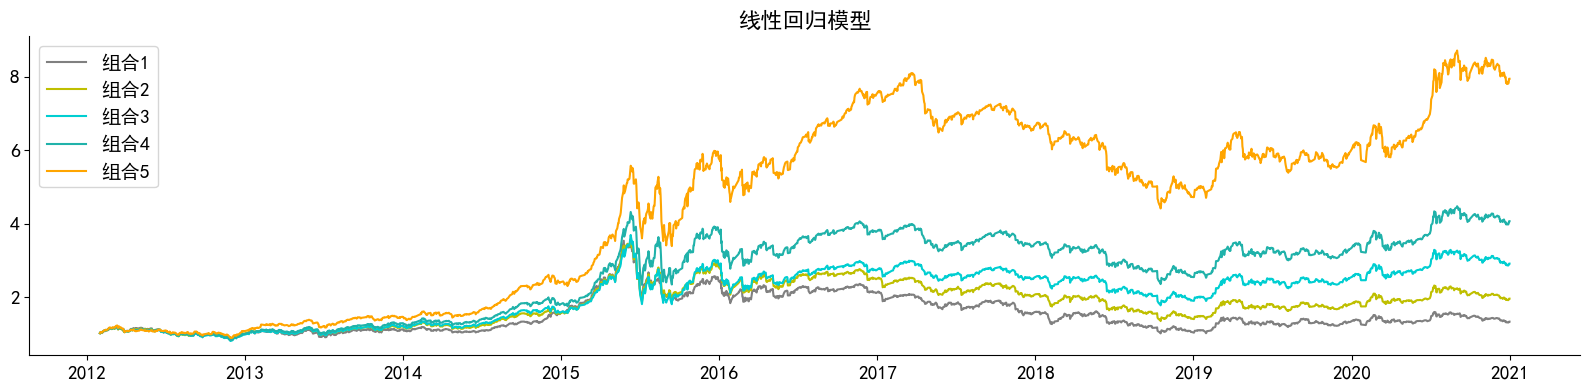

In [21]:
equity_curve_plot(ret_cumprodlist)

In [22]:
#得到五组的策略指标
indicators=[]
for i in range(5):
    indicators.append(out_put_panel(ret_list[i],ret_cumsumlist[i],1e8))
result_data=pd.concat(indicators,axis=0)
result_data.index=["组合1","组合2","组合3","组合4","组合5"] 
result_data

,总收益率,年化收益率,年化波动率,胜率,盈亏比,最大回撤,夏普比,卡玛比,最大回撤开始时间,最大回撤结束时间
组合1,0.640739,0.073716,0.284881,0.532904,0.917880,1.062885,0.258761,0.069355,2015-05-26,2018-10-17
组合2,1.015088,0.116784,0.279847,0.544869,0.901026,0.785121,0.417314,0.148747,2015-06-11,2018-10-17
组合3,1.415531,0.162855,0.280973,0.562816,0.865175,0.681707,0.579609,0.238892,2015-06-11,2015-07-07
组合4,1.736781,0.199814,0.275696,0.571100,0.860227,0.592223,0.724762,0.337396,2015-06-11,2015-07-07
组合5,2.363257,0.271889,0.257184,0.579383,0.882918,0.582667,1.057177,0.466628,2017-03-23,2018-10-17


In [23]:
#滑点分析，代码与get_ret函数内基本相同，滑点分别设置为0.05，0.1，0.15
def silp_ret(temp_close):
    account = 1e8
    count = temp_close.count(axis=1)
    count = account/count
    pos = np.ceil((count/100/temp_close.T).T)
    ret = pos*(temp_close.shift(-1)-temp_close)*100

    pos_chg = pos.diff()
    pos_chg.iloc[0] = pos.iloc[0]
    pos_chg = abs(pos_chg)

    ret_daily = ret.sum(axis=1)
    slip = (pos_chg*100*0.05).sum(axis=1)
    ret_daily = (ret_daily - slip.T).T
    #计算不同滑点费用下的每日收益
    ret_daily = ret.sum(axis=1)
    slip = pd.concat([(pos_chg*100*0.01*slip).sum(axis=1) for slip in [5,10,15]],axis=1)
    ret_daily = (ret_daily - slip.T).T
    ret_daily.columns = 'slip5,slip10,slip15'.split(',')
    return ret_daily

In [24]:
ret_group5=silp_ret(temp_closelist[4])

In [26]:
#绘制不同滑点的组合净值曲线
def silp_curve_plot(plot_data):
    allcolor=["grey","darkturquoise","orange"]
    fig,ax=plt.subplots(figsize=(16,4),tight_layout=True)
    for i in range(len(plot_data.columns)):
        ax.plot(plot_data.iloc[:,i],color=allcolor[i])
    ax.legend(["silp0.05","silp0.10","silp0.15"],loc='upper left',fontsize=14)
    ax.set_title("滑点分析",fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=14)
    plt.rcParams["font.sans-serif"] = ["SimHei"]
    plt.rcParams["axes.unicode_minus"] = False

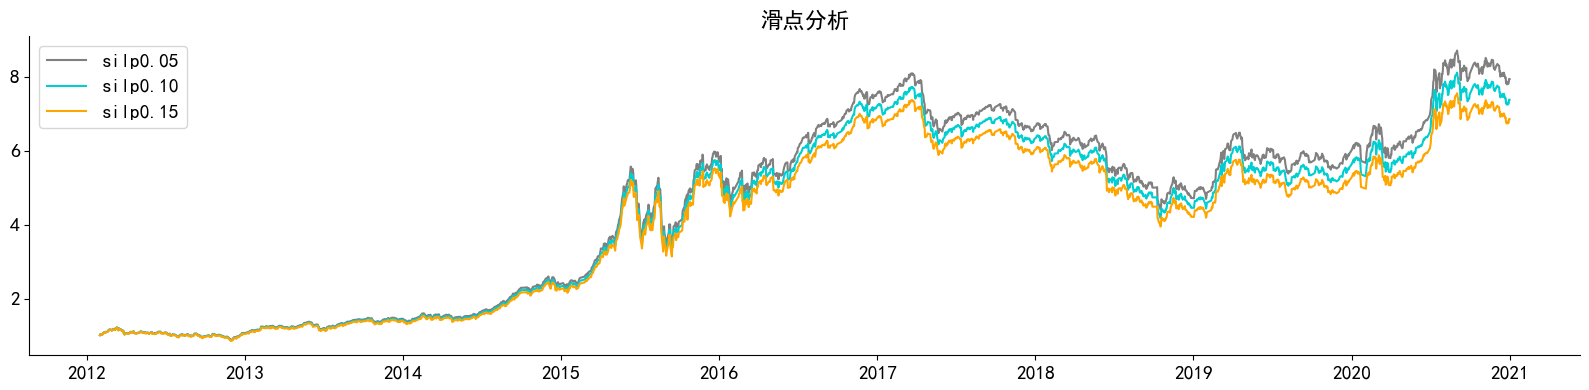

In [27]:
#这里选择在不同滑点下组合5的资金曲线绘制
group5_cumprod=(1+ret_group5/1e8).cumprod()
silp_curve_plot(group5_cumprod)

In [28]:
#对不同滑点费用的策略计算指标
ret_cumsum_group5=ret_group5.cumsum()
result_silp5 = out_put_panel(ret_group5.iloc[:,0],ret_cumsum_group5.slip5,1e8)
result_silp10 = out_put_panel(ret_group5.iloc[:,1],ret_cumsum_group5.slip10,1e8)
result_silp15 = out_put_panel(ret_group5.iloc[:,2],ret_cumsum_group5.slip15,1e8)
result = pd.concat([result_silp5,result_silp10,result_silp15])
result.index = ['slip5','slip10','slip15']
result

,总收益率,年化收益率,年化波动率,胜率,盈亏比,最大回撤,夏普比,卡玛比,最大回撤开始时间,最大回撤结束时间
slip5,2.363257,0.271889,0.257184,0.579383,0.882918,0.582667,1.057177,0.466628,2017-03-23,2018-10-17
slip10,2.289956,0.263456,0.257155,0.577543,0.884296,0.590604,1.024501,0.446079,2017-03-23,2018-10-17
slip15,2.216655,0.255022,0.257129,0.576162,0.883995,0.598540,0.991807,0.426074,2017-03-23,2018-10-17
